# Using Machine Learning to Predict NBA Over/Under
### Nathaniel Jones
***

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics
import scipy.stats as stats 

## Import data
First I'll need to bring in the data being used. The NBA 2023-2024 data is from Basketball Reference (https://www.basketball-reference.com/leagues/NBA_2024_games-october.html). This NBA data contains scores and stats from every game during the 2023-2024 season. The betting data was found on Kaggle (https://www.kaggle.com/datasets/cviaxmiwnptr/nba-betting-data-october-2007-to-june-2024). The user on Kaggle has compiled a dataset containing scores, point spreads, totals, and other odds from all NBA games from 2007 to 2024.

In [5]:
# Read in NBA data for 2023-2024 season
nba_df = pd.read_csv('/Users/nathanieljones/Library/CloudStorage/OneDrive-AppalachianStateUniversity/Spring 2025/CIS 5685 Programming/Final Project/nba_2023_24_gamelog.csv')

In [6]:
# Read in betting data
betting_df = pd.read_csv('/Users/nathanieljones/Library/CloudStorage/OneDrive-AppalachianStateUniversity/Spring 2025/CIS 5685 Programming/Final Project/nba_2008-2024.csv')

In [7]:
# Check data
print(nba_df.head())
print(betting_df.head())

              Date             Visitor  PTS                   Home  PTS.1
0  Tue Oct 24 2023  Los Angeles Lakers  107         Denver Nuggets    119
1  Tue Oct 24 2023        Phoenix Suns  108  Golden State Warriors    104
2  Wed Oct 25 2023     Houston Rockets   86          Orlando Magic    116
3  Wed Oct 25 2023      Boston Celtics  108        New York Knicks    104
4  Wed Oct 25 2023  Washington Wizards  120         Indiana Pacers    143
   season      date  regular  playoffs  away home  score_away  score_home  \
0    2008  10/30/07     True     False   por   sa          97         106   
1    2008  10/30/07     True     False  utah   gs         117          96   
2    2008  10/30/07     True     False   hou  lal          95          93   
3    2008  10/31/07     True     False   phi  tor          97         106   
4    2008  10/31/07     True     False   wsh  ind         110         119   

   q1_away  q2_away  ...  ot_home  whos_favored  spread  total  \
0       26       23  ...   

## Adjustments
The nba_df date column is formatted differently than the betting_df. To merge these datasets, I will need to get both datasets in the same date format to match games properly. I will also filter only for the season of interest, 2023-2024. 

In [9]:
# Adjust Date columns for merge
nba_df['Date'] = pd.to_datetime(nba_df['Date'], format='%a %b %d %Y')
betting_df['date'] = pd.to_datetime(betting_df['date'], format='%m/%d/%y')

In [10]:
# Filter only 2023–24 season
seasons_of_interest = [2024]
betting_df = betting_df[betting_df['season'].isin(seasons_of_interest)]

In [11]:
# Merge on date column to combine datasets
merged_df = nba_df.merge(betting_df, left_on='Date', right_on='date', how='left')

In [12]:
print(merged_df.head())
merged_df.info()

        Date             Visitor  PTS                   Home  PTS.1  season  \
0 2023-10-24  Los Angeles Lakers  107         Denver Nuggets    119    2024   
1 2023-10-24  Los Angeles Lakers  107         Denver Nuggets    119    2024   
2 2023-10-24        Phoenix Suns  108  Golden State Warriors    104    2024   
3 2023-10-24        Phoenix Suns  108  Golden State Warriors    104    2024   
4 2023-10-25     Houston Rockets   86          Orlando Magic    116    2024   

        date  regular  playoffs away  ... ot_home  whos_favored  spread  \
0 2023-10-24     True     False  lal  ...       0          home     4.5   
1 2023-10-24     True     False  phx  ...       0          home     3.5   
2 2023-10-24     True     False  lal  ...       0          home     4.5   
3 2023-10-24     True     False  phx  ...       0          home     3.5   
4 2023-10-25     True     False   no  ...       0          home     1.5   

   total  moneyline_away  moneyline_home  h2_spread  h2_total  id_spread  

In [13]:
merged_df = merged_df.rename(columns={"Visitor": "visitor_team", "Home": "home_team"})

## Variables of Interest
The merged_df has many variables, most of them not being necessary for this analysis. I will create a model_df containing only the relevant variables for the over/under model. 

In [15]:
model_df = merged_df[[
    'Date',
    'visitor_team',
    'score_away',
    'home_team',
    'score_home',
    'total',
    'id_total'
]].copy()

In [16]:
print(model_df)

            Date        visitor_team  score_away              home_team  \
0     2023-10-24  Los Angeles Lakers         107         Denver Nuggets   
1     2023-10-24  Los Angeles Lakers         108         Denver Nuggets   
2     2023-10-24        Phoenix Suns         107  Golden State Warriors   
3     2023-10-24        Phoenix Suns         108  Golden State Warriors   
4     2023-10-25     Houston Rockets         111          Orlando Magic   
...          ...                 ...         ...                    ...   
11022 2024-04-14     Detroit Pistons         120      San Antonio Spurs   
11023 2024-04-14     Detroit Pistons         124      San Antonio Spurs   
11024 2024-04-14     Detroit Pistons          95      San Antonio Spurs   
11025 2024-04-14     Detroit Pistons         116      San Antonio Spurs   
11026 2024-04-14     Detroit Pistons         126      San Antonio Spurs   

       score_home  total  id_total  
0             119  228.5       0.0  
1             104  235.5 

# Create New Variables
To help build the model, I want to create a combined actual game score column. This will be useful in assessing how far the Vegas line was from the actual final score. I also will create a rolling average column to assess how a team is playing as a whole, given game scores can vary quite a bit each game.

In [18]:
# Build total combined score
model_df['actual_total'] = model_df['score_home'] + model_df['score_away']

In [19]:
# Create 3 game rolling average
model_df['rolling_avg_total'] = model_df['actual_total'].shift(1).rolling(window=3, min_periods=1).mean()

# Capture difference of game total vs vegas line
model_df['diff_from_vegas'] = model_df['actual_total'] - model_df['total']

In [20]:
# Drop rows containing NaN
model_df.dropna(inplace=True)


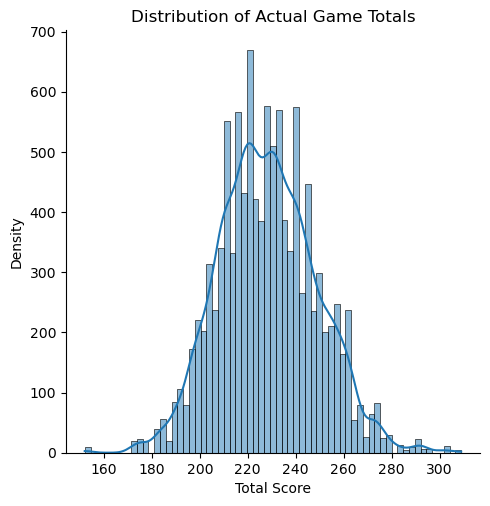

In [21]:
sns.displot(model_df['actual_total'], kde=True)
plt.xlabel('Total Score')
plt.ylabel('Density')
plt.title('Distribution of Actual Game Totals')
plt.show()

## Build Logistic Regression
For this data, since id_total is binary, we will train and use a logistic regression model. 

In [23]:
X = model_df[['rolling_avg_total', 'actual_total']] 
y = model_df['id_total']  # 1 = Over, 0 = Under

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

## Evaluate Accuracy
Does the model accurately predict game outcomes?

In [25]:
# Evaluate model
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.68      0.99      0.80       920
         1.0       0.99      0.66      0.79      1279

    accuracy                           0.80      2199
   macro avg       0.83      0.82      0.80      2199
weighted avg       0.86      0.80      0.80      2199



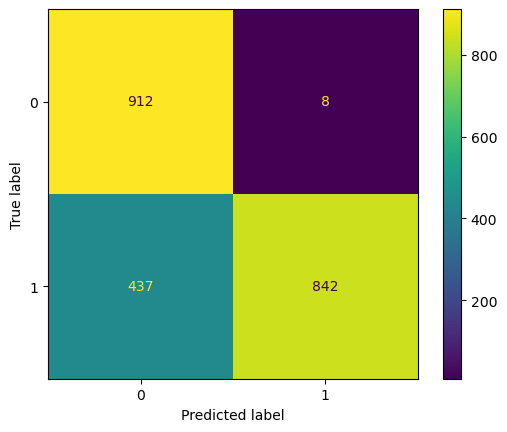

In [26]:
cm = metrics.confusion_matrix(y_test, preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

## Model Assessment
Looking at the data, the model is overall 80% accurate. The model tends to predict the under more than the over. When it predicts the over, it is almost never wrong. When predicting the under, it is less accurate, but still fairly accurate.  

## User Input
Let's use our model to make some money. Input tonight's over/under and get the odds of the over hitting.

In [48]:

# User input for team name and over/under value
team_name = input("Input team name: ")
over_under = float(input("What is the over/under? "))

# Filter the data for the specified team
team_data = model_df[(model_df['home_team'] == team_name) | (model_df['visitor_team'] == team_name)].copy()

# Calculate the probability of the over hitting
team_data.loc[:, 'predicted_prob'] = model.predict_proba(team_data[['rolling_avg_total', 'actual_total']])[:, 1]

# Display the probability
print(f"The probability of the over hitting for {team_name} with an over/under of {over_under} is {team_data['predicted_prob'].mean():.2f}")


Input team name:  Atlanta Hawks
What is the over/under?  225


The probability of the over hitting for Atlanta Hawks with an over/under of 225.0 is 0.46


In [51]:
import nbformat
from nbconvert import HTMLExporter

# Read the notebook file
with open('Revised Final.ipynb', 'r') as f:
    notebook_content = f.read()

# Convert the notebook to HTML
notebook_node = nbformat.reads(notebook_content, as_version=4)
html_exporter = HTMLExporter()
html_exporter.template_name = 'basic'
html_content, _ = html_exporter.from_notebook_node(notebook_node)

# Save the HTML content to a file
with open('Revised Final.html', 'w') as f:
    f.write(html_content)
